In [1]:
import cv2
import numpy as np
from funcs import *

In [2]:
mask = cv2.imread('created_masks/UCSB-IZC00046621_5x_hef_lg/eyes.png'
                  , cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

## Visualize the Contours 

In [90]:
cnt = contours[0]
canvas = np.zeros_like(mask)
canvas.fill(255)
canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)

# find the bounding box of the contour 
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
angle1 = rect[2]

# is it left eye or right eye
direction = "right"

if angle1 > 45 and direction == "left":
    # rotate the eye to make the following code works
    cnt = rotate_contour(cnt, 90-angle1)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

if angle1 > 45 and direction == "right":
    # rotate the eye to make the following code works
    cnt = rotate_contour(cnt, 90-angle1)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

cv2.drawContours(canvas,[box],0,(0,255,),5)
cv2.drawContours(canvas, cnt, -1, (0, 255, 0), 5)

# find the centroid of the shape
M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
centroid_point = (cx,cy)
cv2.circle(canvas, (cx, cy), radius=20, color=(0, 0, 255), thickness=-1)


if direction == "right":
    sorted_indices = np.argsort(-box[:, 0])
    right_two_indexes = sorted_indices[:2]
    right_two_points = box[right_two_indexes]
    right1 = right_two_points[0]
    right2 = right_two_points[1]

    point1, index1= find_closest_point(centroid_point, tuple(right1), cnt)
    point2, index2 = find_closest_point(centroid_point, tuple(right2), cnt)
    cv2.line(canvas, centroid_point, tuple(right1), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.line(canvas, centroid_point, tuple(right2), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.circle(canvas, tuple(point1), 20, (255, 0, 0), -1)
    cv2.circle(canvas, tuple(point2), 20, (255, 0, 0), -1)
    print(angle_between_3_points(right1, centroid_point, right2))

if direction == "left":

    sorted_indices = np.argsort(box[:, 0])
    left_two_indexes = sorted_indices[:2]
    left_two_points = box[left_two_indexes]
    left1 = left_two_points[0]
    left2 = left_two_points[1]

    point1, index1= find_closest_point(centroid_point, tuple(left1), cnt)
    point2, index2 = find_closest_point(centroid_point, tuple(left2), cnt)
    cv2.line(canvas, centroid_point, tuple(left1), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.line(canvas, centroid_point, tuple(left2), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.circle(canvas, tuple(point1), 20, (255, 0, 0), -1)
    cv2.circle(canvas, tuple(point2), 20, (255, 0, 0), -1)
    print(angle_between_3_points(left1, centroid_point, left2))


line_contour = np.array([centroid_point, tuple(box[2])]).reshape((-1, 1, 2)).astype(np.int32)

cv2.namedWindow("binary", cv2.WINDOW_NORMAL)
cv2.imshow('binary', canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()

133.44641634986323


In [4]:
## segment the contour 
index = np.sort([index1, index2])
segments = np.split(cnt, index)[1]

In [5]:
canvas = np.zeros_like(mask)
canvas.fill(255)
canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
cv2.drawContours(canvas, segments, -1, (0, 255, 0), 5)

cv2.namedWindow("binary", cv2.WINDOW_NORMAL)
cv2.imshow('binary', canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()


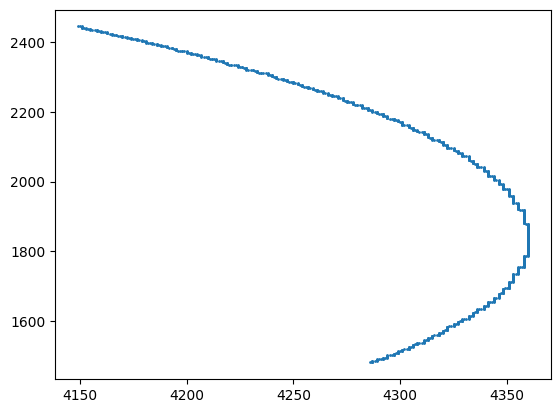

In [6]:
# project contours into R^2 
from scipy.spatial import distance

coords = segments.reshape((len(segments), 2))
x_values = [coord[0] for coord in coords]
y_values = [coord[1] for coord in coords]


plt.scatter(x_values, y_values, s=1)
plt.show()


In [7]:
# distance between adjacent points in the contour
distances = [distance.euclidean(coords[i], coords[i+1]) for i in range(len(coords)-1)]
print(list(set(distances)))
coords.shape

[1.0, 1.4142135623730951]


(1128, 2)

In [8]:
import math

def find_point_on_line(points, total_distance, start_point, start_index):
    accumulated_distance = 0
    current_point = start_point
    
    for i in range(start_index+1, len(points)):
        distance = math.sqrt((points[i][0] - current_point[0])**2 + (points[i][1] - current_point[1])**2)
        if accumulated_distance + distance >= total_distance:
            update_index = i
            remaining_distance = total_distance - accumulated_distance
            proportion = remaining_distance / distance
            x = current_point[0] + (points[i][0] - current_point[0]) * proportion
            y = current_point[1] + (points[i][1] - current_point[1]) * proportion
            #print(accumulated_distance)
            return update_index, [x, y]
        else:
            accumulated_distance += distance
            current_point = points[i]
    
    # If we reach the end of the array, return the last point
    return points[-1]


## Points Sampling Example

In [9]:
import random
# sample size 
num_omma = 8
omma_diameter_pixel = 25
# make sure no out of range
upper_bound = int(np.ceil(omma_diameter_pixel*num_omma))
new_coords = coords[:-abs(upper_bound)]
start = random.choice(new_coords)

In [10]:
# problem with updating current_index
omma_points = []
current_omma = start
new_coords_omma = coords.copy()
current_index = np.where((new_coords_omma == current_omma).all(axis=1))[0][0]

i = 0 
while i < num_omma:
    i += 1
    current_index, next_omma = find_point_on_line(new_coords_omma, omma_diameter_pixel, current_omma, current_index)
    new_coords_omma = np.insert(new_coords_omma, current_index - 1, next_omma, axis = 0)
    omma_points.append(next_omma)
    current_omma = next_omma
    

In [11]:
# coordninates of sampled ommatidia
print("The coordinates of sampled ommatidia are:")
omma_points

The coordinates of sampled ommatidia are:


[[4349.171572875254, 1978.0],
 [4353.0, 1956.2426406871189],
 [4355.0, 1932.656854249492],
 [4358.0, 1910.071067811865],
 [4358.0, 1885.071067811865],
 [4360.0, 1861.4852813742382],
 [4360.0, 1836.4852813742382],
 [4360.0, 1811.4852813742382]]

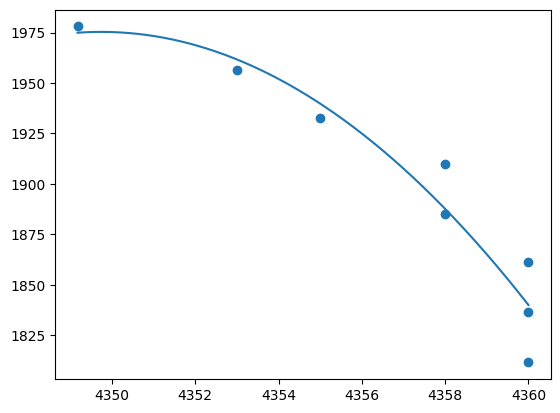

In [12]:
# fit the sampled points to a polynomial regression
from scipy.optimize import curve_fit

x = np.array([p[0] for p in omma_points])
y = np.array([p[1] for p in omma_points])

coeffs = np.polyfit(x, y, 2)
curve = np.poly1d(coeffs)
# plot the closed curve 
xp = np.linspace(x[0], x[-1], 1000)
plt.plot(xp, curve(xp))
plt.scatter(x,y)
plt.show()

## Sampling Radius of Curvature(estimated by circle fitting)

In [13]:
# parameters can be tuned:
# num_omma(5): number of sampling ommatidia; choose smaller number if the eye is small
# number of iteration(10000): sample size  
# omma_diameter_pixel: ommatidia diameter measured in pixels 
# threshold of sse(10): lower threshold means the polynomial regression(k=2)
#                   can capture the poistion of ommatidia more correctly

from tqdm import tqdm
radius_curvature_list = []
radius_list = []

for i in tqdm(range(10000)):
    num_omma = 8
    omma_diameter_pixel = 30
    upper_bound = int(np.ceil(omma_diameter_pixel*num_omma))
    new_coords = coords[:-abs(upper_bound)]
    start = random.choice(new_coords)

    omma_points = []
    current_omma = start
    new_coords_omma = coords.copy()
    current_index = np.where((new_coords_omma == current_omma).all(axis=1))[0][0]

    i = 0 
    while i < num_omma:
        i += 1
        current_index, next_omma = find_point_on_line(new_coords_omma, omma_diameter_pixel, current_omma, current_index)
        #print(current_index)
        new_coords_omma = np.insert(new_coords_omma, current_index - 1, next_omma, axis = 0)
        omma_points.append(next_omma)
        current_omma = next_omma
    
    x = np.array([p[0] for p in omma_points])
    xp = np.linspace(x[0], x[-1], 8)
    y = np.array([p[1] for p in omma_points])

    coeffs = np.polyfit(x, y, 2)
    y_fit = np.polyval(coeffs, x)
    sse = np.sum((y_fit - y)**2)

    if sse > 10:
        continue 
    else:
        poly_curve = np.poly1d(coeffs)
        #circle_fit = ls_circle(xp,poly_curve(xp))
        circle_fit = ls_circle(x,y)
        radius_list.append(circle_fit[2]) 
        # deriv1 = poly_curve.deriv()
        # deriv2 = deriv1.deriv()
        # radius = ((1 + deriv1(xp)**2)**1.5) / abs(deriv2(xp))
        # print(radius)
        # radius_curvature_list.append(radius)


100%|██████████| 10000/10000 [00:05<00:00, 1927.72it/s]


In [14]:
# exclude outliers 
if not isinstance(radius_list, np.ndarray):
    radius_list = np.array(radius_list, dtype=float)
threshold = 2  # threshold for Z-score method

mean = np.mean(radius_list)
std = np.std(radius_list)
z_scores = np.abs((radius_list - mean) / std)
filtered_data = radius_list[z_scores < threshold]
filtered_data = filtered_data[filtered_data<2000]

In [15]:
from scipy import stats
from scipy.stats import mode

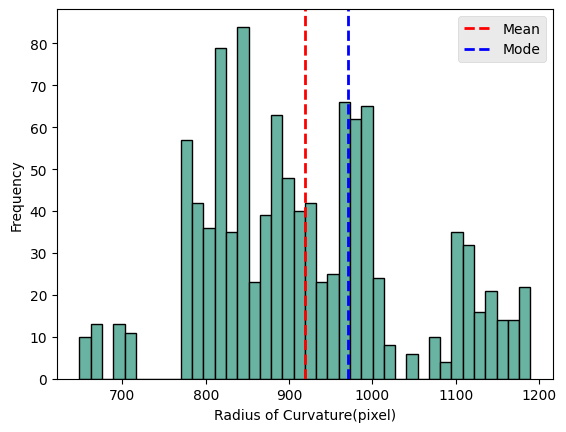

In [16]:
plt.hist(filtered_data,edgecolor='black', color='#69b3a2', bins = 40)
plt.style.use('ggplot')
# plt.figure(figsize=(8,6))
plot_mean = np.mean(filtered_data)
plot_mode = mode(filtered_data.astype(int),keepdims=True)[0][0]
plt.axvline(plot_mean, color='red', linestyle='--', linewidth=2)
plt.axvline(plot_mode, color='blue', linestyle='--', linewidth=2)
# plt.text(x=plot_mean+5, y=120, s=f'Mean={plot_mean:.4f}', fontdict=dict(color='red', size=10))
# plt.text(x=plot_mode+5, y=300, s=f'Mode={plot_mode:.1f}', fontdict=dict(color='blue', size=10))
plt.legend(['Mean','Mode'])
plt.xlabel('Radius of Curvature(pixel)')
plt.ylabel('Frequency')

plt.show()


In [18]:
# confidence interval with larger sample(n>30)
import numpy as np
import scipy.stats as st

print("The 95% confidence interval of radius of curvature is:")
st.norm.interval(confidence=0.95, loc=np.mean(filtered_data), scale=st.sem(filtered_data))

The 95% confidence interval of radius of curvature is:


(911.8201127792308, 926.1392484382702)

## Sampling Interommatidial Angles

Problems:
1. slow algorithm to find two points with fixed distance on curve(need help)

In [128]:

def find_x2(arc_length, x1, integrand):
    # Integrate the integrand over the interval from x1 to x2 to get the arc length
    x2 = x1  # Initialize x2 to be x1
    #print(x1)
    arc_length_temp = 0.0
    
    while arc_length_temp < arc_length:
        x2 += 1 
        arc_length_temp, _ = quad(integrand, x1, x2)
        
    while arc_length_temp > arc_length:
        x2 -= 0.003
        arc_length_temp, _ = quad(integrand, x1, x2)
            
    return x2

Able to achieve accuracy after 2 decimal points

In [132]:
import time

start_time = time.time()

dp_dx = poly_curve.deriv()
def integrand_test(x):
    return np.sqrt(1 + dp_dx(x)**2)

x_omma1 = np.random.uniform(xp[0],xp[-1])
y_omma1 = poly_curve(x_omma1)

arc_length = 15.3761
x_omma2 = find_x2(arc_length, x_omma1, integrand_test)
arc_length, _ = quad(integrand_test, x_omma1, x_omma2)

end_time = time.time()
running_time = end_time - start_time
print("Running time:", running_time, "seconds")
print(arc_length)

Running time: 0.003997087478637695 seconds
15.372455556063672


In [88]:
angle_list = []

for i in tqdm(range(500)):
    # change number of omma and omma diameter here to sample
    # good polynomial regression
    num_omma = 6
    omma_diameter_pixel = 40
    upper_bound = int(np.ceil(omma_diameter_pixel*num_omma))
    new_coords = coords[:-abs(upper_bound)]
    start = random.choice(new_coords)

    omma_points = []
    current_omma = start
    new_coords_omma = coords.copy()
    current_index = np.where((new_coords_omma == current_omma).all(axis=1))[0][0]

    i = 0 
    while i < num_omma:
        i += 1
        current_index, next_omma = find_point_on_line(new_coords_omma, omma_diameter_pixel, current_omma, current_index)
        new_coords_omma = np.insert(new_coords_omma, current_index - 1, next_omma, axis = 0)
        omma_points.append(next_omma)
        current_omma = next_omma
    
    x = np.array([p[0] for p in omma_points])
    xp = np.linspace(x[0], x[-1], 1000)
    y = np.array([p[1] for p in omma_points])

    coeffs = np.polyfit(x, y, 2)
    y_fit = np.polyval(coeffs, x)
    sse = np.sum((y_fit - y)**2)

    if sse > 10:
        continue 
    else:
        poly_curve = np.poly1d(coeffs)
        deriv1 = poly_curve.deriv()

        def integrand(x):
            return np.sqrt(1 + deriv1(x)**2) 
        
        for i in range(30):
            x_omma1 = np.random.uniform(xp[0],xp[-1])
            y_omma1 = poly_curve(x_omma1)
    
            arc_length = 0.0215/0.00117
            x_omma2 = find_x2(arc_length, x_omma1, integrand)
            if x_omma2 > xp[-1]:
                continue

            y_omma2 = poly_curve(x_omma2)
            d1 = deriv1(x_omma1)
            d2 = deriv1(x_omma2)
            m1 = -1/d1
            b1 = y_omma1 - m1 * x_omma1
            m2 = -1/d2
            b2 = y_omma2 - m2 * x_omma2
            x_intersect = (b2 - b1) / (m1 - m2)
            y_intersect = m1 * x_intersect + b1

            angle = np.arctan(abs((m2 - m1) / (1 + m1 * m2)))
            #print(angle)
            angle_list.append(angle)       

100%|██████████| 500/500 [07:02<00:00,  1.18it/s]


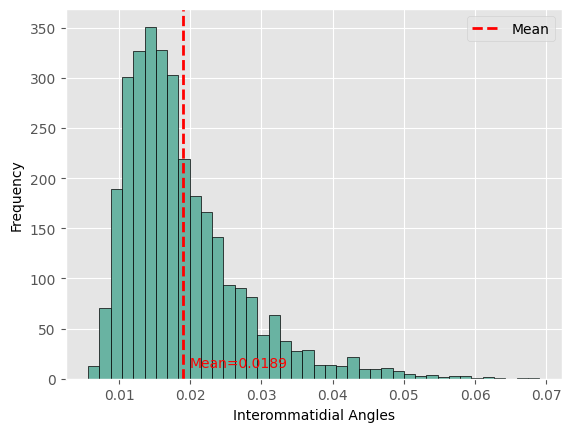

In [89]:
plt.hist(angle_list,edgecolor='black', color='#69b3a2', bins = 40)
plt.style.use('ggplot')
# plt.figure(figsize=(8,6))
plot_mean = np.mean(angle_list)
#plot_mode = mode(np.array(angle_list,dtype=float) , keepdims=True)[0][0]
plt.axvline(plot_mean, color='red', linestyle='--', linewidth=2)
#plt.axvline(plot_mode, color='blue', linestyle='--', linewidth=2)
plt.text(x=plot_mean+0.001, y=12, s=f'Mean={plot_mean:.4f}', fontdict=dict(color='red', size=10))
# plt.text(x=plot_mode+5, y=300, s=f'Mode={plot_mode:.1f}', fontdict=dict(color='blue', size=10))
plt.legend(['Mean'])
plt.xlabel('Interommatidial Angles')
plt.ylabel('Frequency')

plt.show()